In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/cover-art-generation/modelling

/content/drive/MyDrive/cover-art-generation/modelling


In [4]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [5]:
# %matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as daset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd


#Not valid with GPU
"""
# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results
"""


'\n# Set random seed for reproducibility\nmanualSeed = 999\n# manualSeed = random.randint(1, 10000) # use if you want new results\nprint("Random Seed: ", manualSeed)\nrandom.seed(manualSeed)\ntorch.manual_seed(manualSeed)\ntorch.use_deterministic_algorithms(True)  # Needed for reproducible results\n'

In [6]:
genre_dict = {"Chill":0, "Mood":1, "Indie":2,"Pop":3,"At Home":4,"Workout":5,"Rock":6,
              "Dance/Electronic":7,"Latin":8,"Hip-Hop":9,"Flamenco":10,"Top Lists":11,"Focus":12,
             "Romance":13, "Decades":14, "Folk & Acoustic":15, "Latina":16, "Alternative":17,
             "Party":18, "Listas de éxitos":19}

In [7]:
# Root directory for dataset
dataroot = "../dataset"

# Cover path
cover_path = "../dataset/covers_album/"

# num classes
num_classes = 20

# Saving directory
save_dir = "../artifacts/weights_gan"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# Embedding Dim
embedding_dim = 50

In [8]:
image_path = cover_path + '3bq9Ti95fNT2uQ79Y1ENUA.jpeg'
print(image_path)

../dataset/covers_album/3bq9Ti95fNT2uQ79Y1ENUA.jpeg


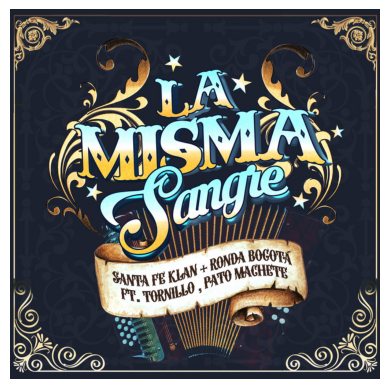

In [9]:
# Load an image
image = Image.open(image_path)

# show image
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
#Class dataset to get the images and the label

class coversdataset(Dataset):
    def __init__(self, path_dataset='', path_cover='', transform=None):
        super().__init__()
        self.frame = pd.read_pickle(dataroot + '/spotify_dataset_cnn.pkl')
        self.cover_path = path_cover
        self.transform = transform

    def __len__(self):
        return self.frame.shape[0]

    def __getitem__(self, idx):
        label = self.frame.iloc[idx]['audio_analysis']

        cover_id = self.frame.loc[idx]['Cover ID']
        image = self.cover_path + cover_id + '.jpeg'
        im = Image.open(image)
        images = im.convert('RGB')

        if self.transform:
            image_transformed = self.transform(images)
            return image_transformed, genre_dict.get(label, 20)
        else:
            return images, genre_dict.get(label, 20)

In [11]:
transform=transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size),
            transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

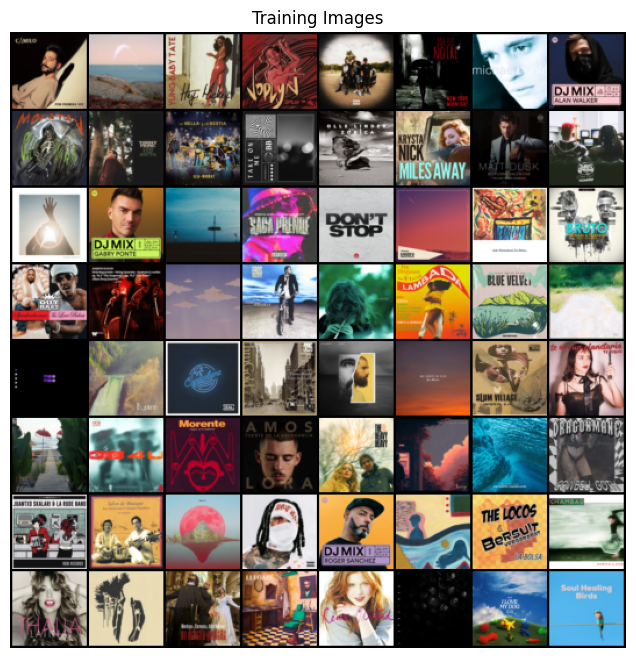

In [12]:
# Create the dataset

dataset = coversdataset(path_cover=cover_path, transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator



In [14]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_linear = nn.Linear(embedding_dim, 7*7)
        self.latent_input = nn.Linear(nz, 128*7*7)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.main = nn.Sequential(
            # input is Z + embedding_channel, going into a convolution
            nn.ConvTranspose2d(129, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 10 x 10``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 13 x 13``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32`` (ngf, nc, 4, 2, 1, bias=False)
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input, label):
        print_shapes = False
        embedded_input = self.embedding(label)
        embedded_input = self.label_linear(embedded_input)
        embedded_input = embedded_input.view(-1, 1, 7, 7)

        if print_shapes:
          print('EmbeddedG {} {}'.format(embedded_input.shape, type(embedded_input)))
          print('InputG {} {}'.format(input.shape, type(input)))

        input = self.latent_input(input)
        input = self.leaky_relu(input)
        input = input.view(-1, 128, 7, 7)

        if print_shapes:
          print('InputG {} {}'.format(input.shape, type(input)))

        concatenated_input = torch.cat((input, embedded_input), dim=1)
        if print_shapes:
          print('concatenatedG: {}'.format(concatenated_input.shape))

        output = self.main(concatenated_input)
        if print_shapes:
          print('output {}'.format(output.shape))

        return output

In [15]:
# Create the generator
netG = Generator(ngpu, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (embedding): Embedding(20, 50)
  (label_linear): Linear(in_features=50, out_features=49, bias=True)
  (latent_input): Linear(in_features=100, out_features=6272, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (main): Sequential(
    (0): ConvTranspose2d(129, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05,

### Discriminator


In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_linear = nn.Linear(embedding_dim, 1*64*64)
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input, label):
        print_shapes = False
        embedded_input = self.embedding(label)
        embedded_input = self.label_linear(embedded_input)

        if print_shapes:
          print('embedded_inputD {}'.format(embedded_input.shape))
          print('inputD {}'.format(input.shape))

        embedded_input = embedded_input.view(-1, 1, 64, 64)
        if print_shapes:
          print(input.shape, embedded_input.shape)

        embedded_input = embedded_input.view(label.size(0), 1, 64, 64)
        concatenated_input = torch.cat((input, embedded_input), dim=1)
        if print_shapes:
          print('concatenatedD {}'.format(concatenated_input.shape))

        return self.main(concatenated_input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (embedding): Embedding(20, 50)
  (label_linear): Linear(in_features=50, out_features=4096, bias=True)
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1,

In [18]:
params = list(netG.parameters())

# Total Generator Parameters
total_params = sum(p.numel() for p in params)
print("Número total de parámetros:", total_params)

Número total de parámetros: 4451243


In [19]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
path_weights = save_dir + f"/netG_{288}.pth"  # Path weights
netG.load_state_dict(torch.load(path_weights))

path_weights = save_dir + f"/netD_{288}.pth"  # Path weights

netD.load_state_dict(torch.load(path_weights))

path_weights = save_dir + f"/optG_{288}.pth"  # Path weights

optimizerG.load_state_dict(torch.load(v))

path_weights = save_dir + f"/optD_{288}.pth"  # Path weights

optimizerD.load_state_dict(torch.load(path_weights))

epochs_ = 288 + 1

In [23]:
from torchvision.utils import make_grid

if False:
  from torchvision.utils import make_grid
  fake = netG(fixed_noise[:], embed_label[:]).detach().cpu()
  grid = make_grid(fake, nrow=16)

  # Convertir la cuadrícula a un arreglo NumPy
  array = grid.permute(1, 2, 0).numpy()

  # Mostrar la imagen utilizando Matplotlib
  plt.imshow(array)
  plt.axis('off')
  plt.show()

In [24]:
print(num_epochs)

200


### Training

Starting Training Loop...
[0/200][0/158]	Loss_D: 0.3954	Loss_G: 3.6496	D(x): 1.0000	D(G(z)): 0.1557 / 0.0883
[0/200][3/158]	Loss_D: 0.0131	Loss_G: 6.2692	D(x): 0.9999	D(G(z)): 0.0123 / 0.0061
[0/200][6/158]	Loss_D: 0.0186	Loss_G: 5.0914	D(x): 1.0000	D(G(z)): 0.0181 / 0.0107
[0/200][9/158]	Loss_D: 0.6210	Loss_G: 2.5455	D(x): 1.0000	D(G(z)): 0.3989 / 0.1542
[0/200][12/158]	Loss_D: 0.0203	Loss_G: 5.6777	D(x): 1.0000	D(G(z)): 0.0197 / 0.0099
[0/200][15/158]	Loss_D: 0.0413	Loss_G: 4.5542	D(x): 0.9999	D(G(z)): 0.0396 / 0.0179
[0/200][18/158]	Loss_D: 0.0018	Loss_G: 7.0783	D(x): 0.9999	D(G(z)): 0.0017 / 0.0014
[0/200][21/158]	Loss_D: 0.0225	Loss_G: 4.7224	D(x): 0.9999	D(G(z)): 0.0221 / 0.0138
[0/200][24/158]	Loss_D: 0.0457	Loss_G: 4.4852	D(x): 0.9996	D(G(z)): 0.0437 / 0.0159
[0/200][27/158]	Loss_D: 0.0023	Loss_G: 6.7902	D(x): 1.0000	D(G(z)): 0.0023 / 0.0019
[0/200][30/158]	Loss_D: 0.0287	Loss_G: 4.9569	D(x): 0.9866	D(G(z)): 0.0106 / 0.0091
[0/200][33/158]	Loss_D: 0.0309	Loss_G: 4.3489	D(x): 0.

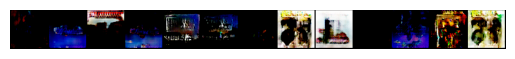

[1/200][0/158]	Loss_D: 0.0071	Loss_G: 5.8092	D(x): 0.9980	D(G(z)): 0.0051 / 0.0042
[1/200][3/158]	Loss_D: 0.0053	Loss_G: 6.1405	D(x): 1.0000	D(G(z)): 0.0053 / 0.0033
[1/200][6/158]	Loss_D: 0.0044	Loss_G: 5.9517	D(x): 0.9999	D(G(z)): 0.0043 / 0.0037
[1/200][9/158]	Loss_D: 0.0285	Loss_G: 4.4284	D(x): 0.9996	D(G(z)): 0.0274 / 0.0163
[1/200][12/158]	Loss_D: 0.0328	Loss_G: 4.3134	D(x): 1.0000	D(G(z)): 0.0320 / 0.0176
[1/200][15/158]	Loss_D: 0.0140	Loss_G: 5.6246	D(x): 0.9989	D(G(z)): 0.0126 / 0.0064
[1/200][18/158]	Loss_D: 0.0640	Loss_G: 3.9268	D(x): 0.9997	D(G(z)): 0.0606 / 0.0266
[1/200][21/158]	Loss_D: 0.0049	Loss_G: 6.5080	D(x): 0.9993	D(G(z)): 0.0042 / 0.0024
[1/200][24/158]	Loss_D: 0.1052	Loss_G: 5.3781	D(x): 0.9104	D(G(z)): 0.0061 / 0.0074
[1/200][27/158]	Loss_D: 0.0042	Loss_G: 6.4030	D(x): 0.9999	D(G(z)): 0.0041 / 0.0029
[1/200][30/158]	Loss_D: 0.0499	Loss_G: 4.4896	D(x): 0.9943	D(G(z)): 0.0428 / 0.0140
[1/200][33/158]	Loss_D: 0.0132	Loss_G: 5.1327	D(x): 0.9998	D(G(z)): 0.0129 / 0.0

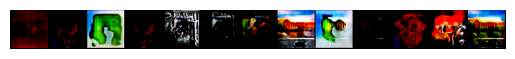

[5/200][0/158]	Loss_D: 1.3984	Loss_G: 5.1045	D(x): 1.0000	D(G(z)): 0.6663 / 0.0160
[5/200][3/158]	Loss_D: 0.0237	Loss_G: 6.0187	D(x): 0.9899	D(G(z)): 0.0130 / 0.0063
[5/200][6/158]	Loss_D: 2.1548	Loss_G: 4.2197	D(x): 0.8839	D(G(z)): 0.7251 / 0.0794
[5/200][9/158]	Loss_D: 0.0038	Loss_G: 8.0260	D(x): 0.9993	D(G(z)): 0.0031 / 0.0021
[5/200][12/158]	Loss_D: 0.0197	Loss_G: 5.4804	D(x): 0.9996	D(G(z)): 0.0185 / 0.0104
[5/200][15/158]	Loss_D: 0.0096	Loss_G: 5.3782	D(x): 0.9999	D(G(z)): 0.0094 / 0.0072
[5/200][18/158]	Loss_D: 0.0238	Loss_G: 4.8391	D(x): 0.9999	D(G(z)): 0.0232 / 0.0113
[5/200][21/158]	Loss_D: 0.0281	Loss_G: 5.0645	D(x): 0.9852	D(G(z)): 0.0127 / 0.0087
[5/200][24/158]	Loss_D: 0.0441	Loss_G: 4.1969	D(x): 0.9999	D(G(z)): 0.0426 / 0.0186
[5/200][27/158]	Loss_D: 0.0133	Loss_G: 5.3003	D(x): 0.9999	D(G(z)): 0.0131 / 0.0069
[5/200][30/158]	Loss_D: 1.2619	Loss_G: 5.1051	D(x): 1.0000	D(G(z)): 0.6627 / 0.0157
[5/200][33/158]	Loss_D: 0.0036	Loss_G: 8.1614	D(x): 0.9976	D(G(z)): 0.0013 / 0.0

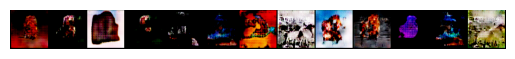

[9/200][0/158]	Loss_D: 0.0012	Loss_G: 7.6282	D(x): 0.9998	D(G(z)): 0.0010 / 0.0012
[9/200][3/158]	Loss_D: 0.0095	Loss_G: 6.0203	D(x): 0.9991	D(G(z)): 0.0085 / 0.0066
[9/200][6/158]	Loss_D: 0.0283	Loss_G: 5.2490	D(x): 0.9998	D(G(z)): 0.0271 / 0.0114
[9/200][9/158]	Loss_D: 0.0051	Loss_G: 5.9462	D(x): 0.9996	D(G(z)): 0.0047 / 0.0035
[9/200][12/158]	Loss_D: 0.0039	Loss_G: 6.5835	D(x): 0.9997	D(G(z)): 0.0036 / 0.0024
[9/200][15/158]	Loss_D: 2.4744	Loss_G: 0.6560	D(x): 0.1871	D(G(z)): 0.0918 / 0.5549
[9/200][18/158]	Loss_D: 0.0059	Loss_G: 7.2565	D(x): 1.0000	D(G(z)): 0.0058 / 0.0020
[9/200][21/158]	Loss_D: 0.0963	Loss_G: 3.4183	D(x): 1.0000	D(G(z)): 0.0860 / 0.0473
[9/200][24/158]	Loss_D: 0.1365	Loss_G: 4.0862	D(x): 1.0000	D(G(z)): 0.1216 / 0.0236
[9/200][27/158]	Loss_D: 0.0187	Loss_G: 5.0429	D(x): 0.9975	D(G(z)): 0.0159 / 0.0092
[9/200][30/158]	Loss_D: 0.0082	Loss_G: 5.4144	D(x): 1.0000	D(G(z)): 0.0081 / 0.0063
[9/200][33/158]	Loss_D: 0.0582	Loss_G: 4.0464	D(x): 0.9982	D(G(z)): 0.0539 / 0.0

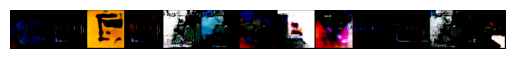

[13/200][0/158]	Loss_D: 0.6029	Loss_G: 2.5952	D(x): 1.0000	D(G(z)): 0.4087 / 0.1354
[13/200][3/158]	Loss_D: 0.0051	Loss_G: 7.3631	D(x): 1.0000	D(G(z)): 0.0051 / 0.0017
[13/200][6/158]	Loss_D: 0.0194	Loss_G: 5.1362	D(x): 0.9998	D(G(z)): 0.0187 / 0.0111
[13/200][9/158]	Loss_D: 0.0079	Loss_G: 5.8932	D(x): 0.9998	D(G(z)): 0.0076 / 0.0054
[13/200][12/158]	Loss_D: 0.4902	Loss_G: 3.1609	D(x): 0.8004	D(G(z)): 0.1515 / 0.0752
[13/200][15/158]	Loss_D: 0.0359	Loss_G: 4.9082	D(x): 0.9999	D(G(z)): 0.0344 / 0.0132
[13/200][18/158]	Loss_D: 0.0202	Loss_G: 4.7946	D(x): 0.9980	D(G(z)): 0.0178 / 0.0124
[13/200][21/158]	Loss_D: 0.0998	Loss_G: 3.8442	D(x): 0.9996	D(G(z)): 0.0901 / 0.0271
[13/200][24/158]	Loss_D: 0.0024	Loss_G: 6.7927	D(x): 0.9998	D(G(z)): 0.0023 / 0.0016
[13/200][27/158]	Loss_D: 0.0314	Loss_G: 4.4178	D(x): 0.9967	D(G(z)): 0.0273 / 0.0165
[13/200][30/158]	Loss_D: 0.0060	Loss_G: 5.6353	D(x): 0.9997	D(G(z)): 0.0057 / 0.0048
[13/200][33/158]	Loss_D: 0.1048	Loss_G: 6.4781	D(x): 0.9086	D(G(z)): 

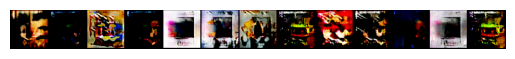

[17/200][0/158]	Loss_D: 0.1523	Loss_G: 3.6560	D(x): 0.9997	D(G(z)): 0.1323 / 0.0405
[17/200][3/158]	Loss_D: 0.0023	Loss_G: 7.2000	D(x): 0.9997	D(G(z)): 0.0020 / 0.0013
[17/200][6/158]	Loss_D: 0.2244	Loss_G: 5.9078	D(x): 0.8213	D(G(z)): 0.0023 / 0.0038
[17/200][9/158]	Loss_D: 0.4350	Loss_G: 2.9279	D(x): 0.9429	D(G(z)): 0.2894 / 0.0915
[17/200][12/158]	Loss_D: 0.0398	Loss_G: 5.1012	D(x): 0.9996	D(G(z)): 0.0378 / 0.0117
[17/200][15/158]	Loss_D: 0.0013	Loss_G: 9.3468	D(x): 0.9997	D(G(z)): 0.0010 / 0.0006
[17/200][18/158]	Loss_D: 0.0041	Loss_G: 4.6259	D(x): 1.0000	D(G(z)): 0.0040 / 0.0207
[17/200][21/158]	Loss_D: 0.3661	Loss_G: 3.9013	D(x): 1.0000	D(G(z)): 0.2776 / 0.0340
[17/200][24/158]	Loss_D: 0.0152	Loss_G: 5.5797	D(x): 1.0000	D(G(z)): 0.0149 / 0.0063
[17/200][27/158]	Loss_D: 0.0082	Loss_G: 5.5176	D(x): 0.9999	D(G(z)): 0.0081 / 0.0064
[17/200][30/158]	Loss_D: 0.0316	Loss_G: 4.4063	D(x): 1.0000	D(G(z)): 0.0305 / 0.0184
[17/200][33/158]	Loss_D: 0.0383	Loss_G: 4.3441	D(x): 0.9999	D(G(z)): 

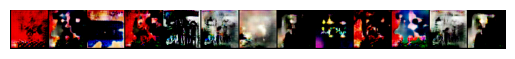

[21/200][0/158]	Loss_D: 0.0782	Loss_G: 3.6744	D(x): 0.9998	D(G(z)): 0.0723 / 0.0490
[21/200][3/158]	Loss_D: 0.0090	Loss_G: 5.9374	D(x): 0.9997	D(G(z)): 0.0086 / 0.0048
[21/200][6/158]	Loss_D: 0.0578	Loss_G: 4.0050	D(x): 0.9992	D(G(z)): 0.0537 / 0.0255
[21/200][9/158]	Loss_D: 0.0026	Loss_G: 6.7728	D(x): 0.9999	D(G(z)): 0.0026 / 0.0017
[21/200][12/158]	Loss_D: 0.0069	Loss_G: 5.9580	D(x): 0.9993	D(G(z)): 0.0062 / 0.0038
[21/200][15/158]	Loss_D: 0.0190	Loss_G: 6.5429	D(x): 1.0000	D(G(z)): 0.0186 / 0.0062
[21/200][18/158]	Loss_D: 0.0070	Loss_G: 6.3411	D(x): 1.0000	D(G(z)): 0.0070 / 0.0037
[21/200][21/158]	Loss_D: 0.0263	Loss_G: 4.6775	D(x): 0.9999	D(G(z)): 0.0256 / 0.0170
[21/200][24/158]	Loss_D: 0.0212	Loss_G: 4.8682	D(x): 0.9925	D(G(z)): 0.0135 / 0.0119
[21/200][27/158]	Loss_D: 0.0258	Loss_G: 4.6839	D(x): 0.9995	D(G(z)): 0.0244 / 0.0125
[21/200][30/158]	Loss_D: 0.0328	Loss_G: 4.5115	D(x): 0.9972	D(G(z)): 0.0293 / 0.0137
[21/200][33/158]	Loss_D: 0.0979	Loss_G: 3.9888	D(x): 0.9983	D(G(z)): 

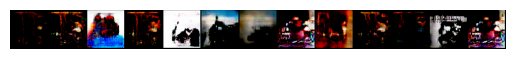

[25/200][0/158]	Loss_D: 2.5553	Loss_G: 6.0283	D(x): 1.0000	D(G(z)): 0.8841 / 0.0059
[25/200][3/158]	Loss_D: 0.0898	Loss_G: 4.1555	D(x): 0.9999	D(G(z)): 0.0758 / 0.0476
[25/200][6/158]	Loss_D: 0.0360	Loss_G: 4.5759	D(x): 0.9943	D(G(z)): 0.0290 / 0.0188
[25/200][9/158]	Loss_D: 0.0540	Loss_G: 5.9898	D(x): 0.9988	D(G(z)): 0.0480 / 0.0131
[25/200][12/158]	Loss_D: 0.0192	Loss_G: 5.4206	D(x): 0.9999	D(G(z)): 0.0186 / 0.0087
[25/200][15/158]	Loss_D: 0.0407	Loss_G: 4.3876	D(x): 0.9984	D(G(z)): 0.0377 / 0.0185
[25/200][18/158]	Loss_D: 0.0591	Loss_G: 5.3135	D(x): 0.9570	D(G(z)): 0.0129 / 0.0078
[25/200][21/158]	Loss_D: 0.8062	Loss_G: 5.7418	D(x): 1.0000	D(G(z)): 0.4958 / 0.0057
[25/200][24/158]	Loss_D: 0.0011	Loss_G: 8.8665	D(x): 0.9999	D(G(z)): 0.0011 / 0.0007
[25/200][27/158]	Loss_D: 0.0009	Loss_G: 8.5888	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[25/200][30/158]	Loss_D: 2.5226	Loss_G: 1.2681	D(x): 0.1684	D(G(z)): 0.0133 / 0.3548
[25/200][33/158]	Loss_D: 0.1004	Loss_G: 5.0895	D(x): 1.0000	D(G(z)): 

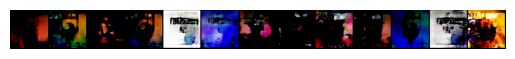

[29/200][0/158]	Loss_D: 0.8032	Loss_G: 4.2075	D(x): 1.0000	D(G(z)): 0.4953 / 0.0331
[29/200][3/158]	Loss_D: 0.0086	Loss_G: 6.7221	D(x): 1.0000	D(G(z)): 0.0084 / 0.0026
[29/200][6/158]	Loss_D: 0.0447	Loss_G: 4.8778	D(x): 0.9999	D(G(z)): 0.0404 / 0.0117
[29/200][9/158]	Loss_D: 0.0109	Loss_G: 5.7534	D(x): 0.9992	D(G(z)): 0.0100 / 0.0049
[29/200][12/158]	Loss_D: 0.0221	Loss_G: 5.7804	D(x): 0.9915	D(G(z)): 0.0132 / 0.0047
[29/200][15/158]	Loss_D: 0.0187	Loss_G: 4.8549	D(x): 0.9994	D(G(z)): 0.0178 / 0.0106
[29/200][18/158]	Loss_D: 0.0777	Loss_G: 4.1787	D(x): 0.9997	D(G(z)): 0.0728 / 0.0196
[29/200][21/158]	Loss_D: 0.0039	Loss_G: 6.6288	D(x): 0.9992	D(G(z)): 0.0031 / 0.0020
[29/200][24/158]	Loss_D: 6.9180	Loss_G: 0.4603	D(x): 0.0025	D(G(z)): 0.0305 / 0.6616
[29/200][27/158]	Loss_D: 0.0009	Loss_G: 9.6763	D(x): 1.0000	D(G(z)): 0.0009 / 0.0002
[29/200][30/158]	Loss_D: 0.0558	Loss_G: 4.4375	D(x): 1.0000	D(G(z)): 0.0508 / 0.0359
[29/200][33/158]	Loss_D: 0.0046	Loss_G: 9.3140	D(x): 0.9999	D(G(z)): 

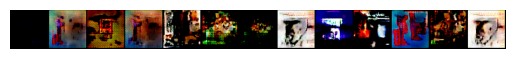

[33/200][0/158]	Loss_D: 0.0041	Loss_G: 6.2511	D(x): 0.9992	D(G(z)): 0.0033 / 0.0030
[33/200][3/158]	Loss_D: 0.0148	Loss_G: 4.7417	D(x): 0.9995	D(G(z)): 0.0141 / 0.0112
[33/200][6/158]	Loss_D: 0.0205	Loss_G: 4.6238	D(x): 0.9999	D(G(z)): 0.0200 / 0.0135
[33/200][9/158]	Loss_D: 0.1029	Loss_G: 3.7493	D(x): 0.9921	D(G(z)): 0.0848 / 0.0309
[33/200][12/158]	Loss_D: 0.0018	Loss_G: 7.0609	D(x): 0.9998	D(G(z)): 0.0016 / 0.0013
[33/200][15/158]	Loss_D: 0.0089	Loss_G: 5.6177	D(x): 0.9964	D(G(z)): 0.0053 / 0.0048
[33/200][18/158]	Loss_D: 5.8135	Loss_G: 1.0893	D(x): 0.0059	D(G(z)): 0.0098 / 0.3801
[33/200][21/158]	Loss_D: 0.0021	Loss_G: 8.0174	D(x): 1.0000	D(G(z)): 0.0021 / 0.0006
[33/200][24/158]	Loss_D: 0.0030	Loss_G: 7.2893	D(x): 0.9997	D(G(z)): 0.0027 / 0.0014
[33/200][27/158]	Loss_D: 0.7563	Loss_G: 3.4213	D(x): 0.9999	D(G(z)): 0.4962 / 0.0517
[33/200][30/158]	Loss_D: 0.0117	Loss_G: 5.6601	D(x): 0.9999	D(G(z)): 0.0115 / 0.0064
[33/200][33/158]	Loss_D: 0.0036	Loss_G: 6.1939	D(x): 0.9999	D(G(z)): 

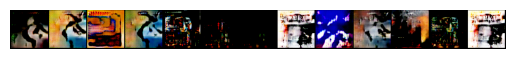

[37/200][0/158]	Loss_D: 0.0185	Loss_G: 4.6514	D(x): 0.9978	D(G(z)): 0.0161 / 0.0125
[37/200][3/158]	Loss_D: 0.0093	Loss_G: 5.3671	D(x): 1.0000	D(G(z)): 0.0093 / 0.0069
[37/200][6/158]	Loss_D: 0.0100	Loss_G: 5.2617	D(x): 0.9999	D(G(z)): 0.0098 / 0.0074
[37/200][9/158]	Loss_D: 3.0391	Loss_G: 0.8286	D(x): 0.0990	D(G(z)): 0.0425 / 0.4699
[37/200][12/158]	Loss_D: 0.0418	Loss_G: 5.9321	D(x): 1.0000	D(G(z)): 0.0402 / 0.0065
[37/200][15/158]	Loss_D: 0.0036	Loss_G: 6.9948	D(x): 0.9999	D(G(z)): 0.0035 / 0.0026
[37/200][18/158]	Loss_D: 0.5187	Loss_G: 3.2116	D(x): 0.9226	D(G(z)): 0.3309 / 0.0563
[37/200][21/158]	Loss_D: 0.0179	Loss_G: 5.0950	D(x): 1.0000	D(G(z)): 0.0176 / 0.0115
[37/200][24/158]	Loss_D: 0.0121	Loss_G: 5.2579	D(x): 1.0000	D(G(z)): 0.0119 / 0.0093
[37/200][27/158]	Loss_D: 0.0317	Loss_G: 4.3012	D(x): 1.0000	D(G(z)): 0.0308 / 0.0206
[37/200][30/158]	Loss_D: 0.0430	Loss_G: 3.9506	D(x): 1.0000	D(G(z)): 0.0415 / 0.0264
[37/200][33/158]	Loss_D: 0.0278	Loss_G: 4.5903	D(x): 1.0000	D(G(z)): 

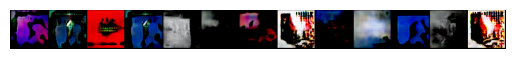

[41/200][0/158]	Loss_D: 0.0087	Loss_G: 5.2537	D(x): 0.9998	D(G(z)): 0.0084 / 0.0068
[41/200][3/158]	Loss_D: 0.0303	Loss_G: 4.3465	D(x): 0.9999	D(G(z)): 0.0295 / 0.0170
[41/200][6/158]	Loss_D: 0.0319	Loss_G: 4.2977	D(x): 0.9923	D(G(z)): 0.0238 / 0.0165
[41/200][9/158]	Loss_D: 0.0167	Loss_G: 4.8392	D(x): 0.9987	D(G(z)): 0.0152 / 0.0111
[41/200][12/158]	Loss_D: 5.0962	Loss_G: 0.6351	D(x): 0.0117	D(G(z)): 0.0244 / 0.5507
[41/200][15/158]	Loss_D: 0.0511	Loss_G: 4.9239	D(x): 0.9999	D(G(z)): 0.0486 / 0.0155
[41/200][18/158]	Loss_D: 1.4067	Loss_G: 1.8043	D(x): 0.3675	D(G(z)): 0.0492 / 0.2275
[41/200][21/158]	Loss_D: 0.0319	Loss_G: 5.4552	D(x): 0.9999	D(G(z)): 0.0308 / 0.0071
[41/200][24/158]	Loss_D: 0.0234	Loss_G: 5.0024	D(x): 0.9991	D(G(z)): 0.0212 / 0.0125
[41/200][27/158]	Loss_D: 0.0063	Loss_G: 5.7253	D(x): 0.9999	D(G(z)): 0.0062 / 0.0051
[41/200][30/158]	Loss_D: 0.0089	Loss_G: 5.2808	D(x): 1.0000	D(G(z)): 0.0088 / 0.0073
[41/200][33/158]	Loss_D: 0.0064	Loss_G: 5.5332	D(x): 0.9998	D(G(z)): 

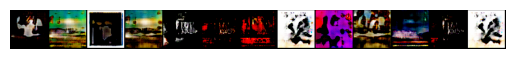

[45/200][0/158]	Loss_D: 1.2246	Loss_G: 3.7924	D(x): 0.9996	D(G(z)): 0.6441 / 0.0415
[45/200][3/158]	Loss_D: 2.5586	Loss_G: 3.1802	D(x): 0.1547	D(G(z)): 0.0069 / 0.0723
[45/200][6/158]	Loss_D: 0.0294	Loss_G: 4.8521	D(x): 1.0000	D(G(z)): 0.0287 / 0.0125
[45/200][9/158]	Loss_D: 0.0336	Loss_G: 4.5014	D(x): 1.0000	D(G(z)): 0.0323 / 0.0162
[45/200][12/158]	Loss_D: 0.0142	Loss_G: 5.0363	D(x): 0.9998	D(G(z)): 0.0137 / 0.0090
[45/200][15/158]	Loss_D: 0.1077	Loss_G: 3.5858	D(x): 0.9999	D(G(z)): 0.0970 / 0.0353
[45/200][18/158]	Loss_D: 3.5582	Loss_G: 1.4180	D(x): 0.0480	D(G(z)): 0.0159 / 0.2781
[45/200][21/158]	Loss_D: 0.0453	Loss_G: 4.8509	D(x): 0.9983	D(G(z)): 0.0418 / 0.0154
[45/200][24/158]	Loss_D: 0.0310	Loss_G: 4.3902	D(x): 1.0000	D(G(z)): 0.0301 / 0.0167
[45/200][27/158]	Loss_D: 0.0800	Loss_G: 3.8184	D(x): 0.9926	D(G(z)): 0.0682 / 0.0305
[45/200][30/158]	Loss_D: 0.1758	Loss_G: 4.4346	D(x): 0.8805	D(G(z)): 0.0193 / 0.0179
[45/200][33/158]	Loss_D: 0.0217	Loss_G: 4.4994	D(x): 0.9996	D(G(z)): 

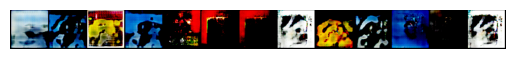

[49/200][0/158]	Loss_D: 0.0251	Loss_G: 4.2409	D(x): 0.9945	D(G(z)): 0.0192 / 0.0205
[49/200][3/158]	Loss_D: 0.1369	Loss_G: 4.7464	D(x): 0.9970	D(G(z)): 0.1217 / 0.0116
[49/200][6/158]	Loss_D: 0.0239	Loss_G: 6.1520	D(x): 0.9803	D(G(z)): 0.0039 / 0.0027
[49/200][9/158]	Loss_D: 0.1003	Loss_G: 5.7743	D(x): 0.9139	D(G(z)): 0.0062 / 0.0040
[49/200][12/158]	Loss_D: 0.0469	Loss_G: 4.2394	D(x): 0.9850	D(G(z)): 0.0311 / 0.0172
[49/200][15/158]	Loss_D: 0.0661	Loss_G: 4.1617	D(x): 0.9983	D(G(z)): 0.0603 / 0.0208
[49/200][18/158]	Loss_D: 0.0439	Loss_G: 5.4116	D(x): 0.9608	D(G(z)): 0.0033 / 0.0057
[49/200][21/158]	Loss_D: 0.0402	Loss_G: 6.3171	D(x): 0.9644	D(G(z)): 0.0031 / 0.0026
[49/200][24/158]	Loss_D: 1.5098	Loss_G: 1.6492	D(x): 0.3299	D(G(z)): 0.1131 / 0.2281
[49/200][27/158]	Loss_D: 0.0543	Loss_G: 4.3410	D(x): 0.9940	D(G(z)): 0.0462 / 0.0182
[49/200][30/158]	Loss_D: 0.0479	Loss_G: 5.1490	D(x): 0.9885	D(G(z)): 0.0352 / 0.0134
[49/200][33/158]	Loss_D: 0.0764	Loss_G: 4.7590	D(x): 0.9622	D(G(z)): 

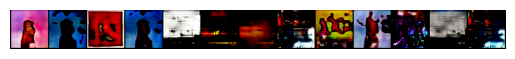

[53/200][0/158]	Loss_D: 0.6130	Loss_G: 2.0819	D(x): 1.0000	D(G(z)): 0.3811 / 0.1983
[53/200][3/158]	Loss_D: 0.0413	Loss_G: 4.9381	D(x): 1.0000	D(G(z)): 0.0390 / 0.0132
[53/200][6/158]	Loss_D: 0.0164	Loss_G: 5.2554	D(x): 1.0000	D(G(z)): 0.0161 / 0.0084
[53/200][9/158]	Loss_D: 0.0162	Loss_G: 4.8910	D(x): 0.9997	D(G(z)): 0.0157 / 0.0106
[53/200][12/158]	Loss_D: 0.0066	Loss_G: 6.4183	D(x): 1.0000	D(G(z)): 0.0065 / 0.0026
[53/200][15/158]	Loss_D: 0.0391	Loss_G: 4.3398	D(x): 0.9988	D(G(z)): 0.0367 / 0.0181
[53/200][18/158]	Loss_D: 0.0401	Loss_G: 4.3975	D(x): 0.9996	D(G(z)): 0.0385 / 0.0162
[53/200][21/158]	Loss_D: 0.0259	Loss_G: 5.0351	D(x): 0.9874	D(G(z)): 0.0130 / 0.0084
[53/200][24/158]	Loss_D: 0.0921	Loss_G: 4.6531	D(x): 0.9284	D(G(z)): 0.0135 / 0.0137
[53/200][27/158]	Loss_D: 0.0120	Loss_G: 5.0673	D(x): 1.0000	D(G(z)): 0.0118 / 0.0084
[53/200][30/158]	Loss_D: 0.0083	Loss_G: 5.6961	D(x): 0.9983	D(G(z)): 0.0065 / 0.0049
[53/200][33/158]	Loss_D: 5.6433	Loss_G: 0.7767	D(x): 0.0078	D(G(z)): 

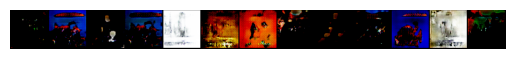

[57/200][0/158]	Loss_D: 2.0287	Loss_G: 3.1801	D(x): 0.9999	D(G(z)): 0.8092 / 0.0562
[57/200][3/158]	Loss_D: 0.0032	Loss_G: 7.6421	D(x): 0.9991	D(G(z)): 0.0023 / 0.0011
[57/200][6/158]	Loss_D: 0.2097	Loss_G: 1.8275	D(x): 1.0000	D(G(z)): 0.1701 / 0.2055
[57/200][9/158]	Loss_D: 0.0130	Loss_G: 5.5464	D(x): 1.0000	D(G(z)): 0.0128 / 0.0079
[57/200][12/158]	Loss_D: 0.0246	Loss_G: 5.1952	D(x): 0.9925	D(G(z)): 0.0167 / 0.0090
[57/200][15/158]	Loss_D: 0.0402	Loss_G: 4.5062	D(x): 0.9828	D(G(z)): 0.0210 / 0.0149
[57/200][18/158]	Loss_D: 0.0092	Loss_G: 5.5241	D(x): 0.9995	D(G(z)): 0.0086 / 0.0057
[57/200][21/158]	Loss_D: 0.0273	Loss_G: 5.3366	D(x): 0.9839	D(G(z)): 0.0108 / 0.0076
[57/200][24/158]	Loss_D: 0.0368	Loss_G: 4.2214	D(x): 0.9988	D(G(z)): 0.0347 / 0.0185
[57/200][27/158]	Loss_D: 0.0105	Loss_G: 5.5469	D(x): 0.9991	D(G(z)): 0.0095 / 0.0057
[57/200][30/158]	Loss_D: 0.0535	Loss_G: 3.9027	D(x): 0.9963	D(G(z)): 0.0480 / 0.0263
[57/200][33/158]	Loss_D: 0.1877	Loss_G: 5.2851	D(x): 0.9960	D(G(z)): 

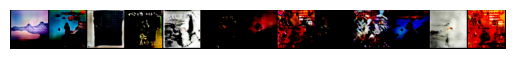

[61/200][0/158]	Loss_D: 1.3504	Loss_G: 2.6021	D(x): 1.0000	D(G(z)): 0.6351 / 0.1158
[61/200][3/158]	Loss_D: 0.0143	Loss_G: 5.9401	D(x): 0.9998	D(G(z)): 0.0138 / 0.0054
[61/200][6/158]	Loss_D: 3.0772	Loss_G: 1.7563	D(x): 0.0992	D(G(z)): 0.0052 / 0.2122
[61/200][9/158]	Loss_D: 0.2954	Loss_G: 3.9829	D(x): 1.0000	D(G(z)): 0.2365 / 0.0263
[61/200][12/158]	Loss_D: 0.0177	Loss_G: 5.2553	D(x): 1.0000	D(G(z)): 0.0170 / 0.0094
[61/200][15/158]	Loss_D: 0.0347	Loss_G: 3.1632	D(x): 1.0000	D(G(z)): 0.0339 / 0.0573
[61/200][18/158]	Loss_D: 0.0346	Loss_G: 4.6311	D(x): 1.0000	D(G(z)): 0.0336 / 0.0132
[61/200][21/158]	Loss_D: 0.0195	Loss_G: 4.6624	D(x): 0.9999	D(G(z)): 0.0191 / 0.0123
[61/200][24/158]	Loss_D: 0.0045	Loss_G: 5.8110	D(x): 0.9999	D(G(z)): 0.0044 / 0.0039
[61/200][27/158]	Loss_D: 0.1460	Loss_G: 4.3043	D(x): 0.9995	D(G(z)): 0.1298 / 0.0274
[61/200][30/158]	Loss_D: 0.0551	Loss_G: 4.2311	D(x): 1.0000	D(G(z)): 0.0526 / 0.0257
[61/200][33/158]	Loss_D: 0.1042	Loss_G: 3.7061	D(x): 1.0000	D(G(z)): 

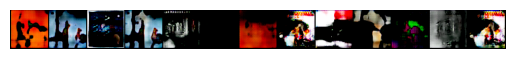

[65/200][0/158]	Loss_D: 0.2190	Loss_G: 1.7309	D(x): 1.0000	D(G(z)): 0.1794 / 0.2282
[65/200][3/158]	Loss_D: 0.0984	Loss_G: 4.7258	D(x): 1.0000	D(G(z)): 0.0895 / 0.0141
[65/200][6/158]	Loss_D: 0.0022	Loss_G: 6.9024	D(x): 0.9999	D(G(z)): 0.0021 / 0.0016
[65/200][9/158]	Loss_D: 0.0109	Loss_G: 5.1676	D(x): 0.9999	D(G(z)): 0.0107 / 0.0088
[65/200][12/158]	Loss_D: 0.0489	Loss_G: 3.9785	D(x): 0.9946	D(G(z)): 0.0419 / 0.0250
[65/200][15/158]	Loss_D: 0.0210	Loss_G: 4.7433	D(x): 0.9986	D(G(z)): 0.0194 / 0.0118
[65/200][18/158]	Loss_D: 0.0239	Loss_G: 5.5730	D(x): 0.9997	D(G(z)): 0.0231 / 0.0074
[65/200][21/158]	Loss_D: 0.0038	Loss_G: 6.4617	D(x): 0.9994	D(G(z)): 0.0031 / 0.0025
[65/200][24/158]	Loss_D: 0.0337	Loss_G: 4.4973	D(x): 0.9931	D(G(z)): 0.0262 / 0.0164
[65/200][27/158]	Loss_D: 0.0647	Loss_G: 4.5223	D(x): 0.9921	D(G(z)): 0.0544 / 0.0148
[65/200][30/158]	Loss_D: 0.1077	Loss_G: 4.9494	D(x): 0.9115	D(G(z)): 0.0108 / 0.0101
[65/200][33/158]	Loss_D: 0.0470	Loss_G: 4.0949	D(x): 0.9959	D(G(z)): 

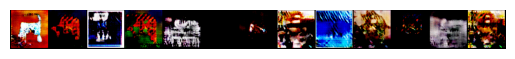

[69/200][0/158]	Loss_D: 0.1958	Loss_G: 6.3094	D(x): 0.8471	D(G(z)): 0.0016 / 0.0056
[69/200][3/158]	Loss_D: 0.1879	Loss_G: 3.6996	D(x): 0.9890	D(G(z)): 0.1460 / 0.0383
[69/200][6/158]	Loss_D: 0.0562	Loss_G: 6.4023	D(x): 0.9516	D(G(z)): 0.0054 / 0.0027
[69/200][9/158]	Loss_D: 0.0624	Loss_G: 4.7124	D(x): 0.9521	D(G(z)): 0.0115 / 0.0122
[69/200][12/158]	Loss_D: 0.3528	Loss_G: 2.1963	D(x): 0.7649	D(G(z)): 0.0494 / 0.1385
[69/200][15/158]	Loss_D: 0.0536	Loss_G: 7.7417	D(x): 0.9514	D(G(z)): 0.0019 / 0.0008
[69/200][18/158]	Loss_D: 0.0591	Loss_G: 3.8945	D(x): 0.9786	D(G(z)): 0.0364 / 0.0264
[69/200][21/158]	Loss_D: 0.0671	Loss_G: 4.8273	D(x): 0.9608	D(G(z)): 0.0258 / 0.0124
[69/200][24/158]	Loss_D: 0.0693	Loss_G: 3.6451	D(x): 0.9851	D(G(z)): 0.0508 / 0.0350
[69/200][27/158]	Loss_D: 0.0607	Loss_G: 4.2478	D(x): 0.9744	D(G(z)): 0.0336 / 0.0199
[69/200][30/158]	Loss_D: 0.0770	Loss_G: 3.2771	D(x): 0.9930	D(G(z)): 0.0666 / 0.0487
[69/200][33/158]	Loss_D: 0.0481	Loss_G: 4.2711	D(x): 0.9911	D(G(z)): 

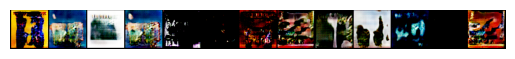

[73/200][0/158]	Loss_D: 0.1533	Loss_G: 2.8728	D(x): 1.0000	D(G(z)): 0.1354 / 0.0918
[73/200][3/158]	Loss_D: 0.0156	Loss_G: 5.1359	D(x): 0.9998	D(G(z)): 0.0151 / 0.0104
[73/200][6/158]	Loss_D: 0.0574	Loss_G: 3.8718	D(x): 0.9993	D(G(z)): 0.0535 / 0.0284
[73/200][9/158]	Loss_D: 0.0563	Loss_G: 4.0141	D(x): 0.9994	D(G(z)): 0.0522 / 0.0249
[73/200][12/158]	Loss_D: 0.0093	Loss_G: 5.3405	D(x): 0.9998	D(G(z)): 0.0090 / 0.0069
[73/200][15/158]	Loss_D: 0.0959	Loss_G: 2.3427	D(x): 1.0000	D(G(z)): 0.0885 / 0.1201
[73/200][18/158]	Loss_D: 0.0684	Loss_G: 4.7056	D(x): 1.0000	D(G(z)): 0.0632 / 0.0173
[73/200][21/158]	Loss_D: 0.0072	Loss_G: 5.5777	D(x): 1.0000	D(G(z)): 0.0071 / 0.0055
[73/200][24/158]	Loss_D: 1.1709	Loss_G: 2.9373	D(x): 0.6844	D(G(z)): 0.4688 / 0.1048
[73/200][27/158]	Loss_D: 0.0134	Loss_G: 5.7990	D(x): 1.0000	D(G(z)): 0.0131 / 0.0062
[73/200][30/158]	Loss_D: 0.0284	Loss_G: 4.7117	D(x): 0.9999	D(G(z)): 0.0273 / 0.0159
[73/200][33/158]	Loss_D: 0.0078	Loss_G: 5.5762	D(x): 1.0000	D(G(z)): 

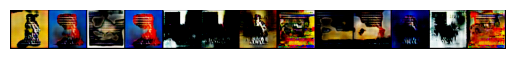

[77/200][0/158]	Loss_D: 0.0963	Loss_G: 3.2882	D(x): 1.0000	D(G(z)): 0.0812 / 0.0594
[77/200][3/158]	Loss_D: 0.1542	Loss_G: 4.2589	D(x): 1.0000	D(G(z)): 0.1326 / 0.0217
[77/200][6/158]	Loss_D: 0.0777	Loss_G: 4.1922	D(x): 0.9966	D(G(z)): 0.0691 / 0.0244
[77/200][9/158]	Loss_D: 0.0309	Loss_G: 5.9447	D(x): 0.9747	D(G(z)): 0.0044 / 0.0041
[77/200][12/158]	Loss_D: 0.0190	Loss_G: 4.8203	D(x): 0.9983	D(G(z)): 0.0170 / 0.0117
[77/200][15/158]	Loss_D: 0.0370	Loss_G: 4.1889	D(x): 0.9999	D(G(z)): 0.0358 / 0.0201
[77/200][18/158]	Loss_D: 0.0195	Loss_G: 4.8989	D(x): 0.9984	D(G(z)): 0.0177 / 0.0099
[77/200][21/158]	Loss_D: 0.0120	Loss_G: 5.0117	D(x): 0.9998	D(G(z)): 0.0116 / 0.0089
[77/200][24/158]	Loss_D: 0.0146	Loss_G: 4.7425	D(x): 0.9998	D(G(z)): 0.0142 / 0.0127
[77/200][27/158]	Loss_D: 0.0044	Loss_G: 6.0589	D(x): 0.9998	D(G(z)): 0.0042 / 0.0036
[77/200][30/158]	Loss_D: 0.0066	Loss_G: 5.6670	D(x): 0.9998	D(G(z)): 0.0063 / 0.0045
[77/200][33/158]	Loss_D: 0.8769	Loss_G: 6.3070	D(x): 1.0000	D(G(z)): 

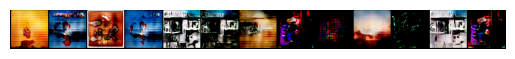

[81/200][0/158]	Loss_D: 0.0251	Loss_G: 4.4620	D(x): 1.0000	D(G(z)): 0.0246 / 0.0154
[81/200][3/158]	Loss_D: 0.0070	Loss_G: 5.5239	D(x): 1.0000	D(G(z)): 0.0069 / 0.0053
[81/200][6/158]	Loss_D: 0.0154	Loss_G: 4.8614	D(x): 0.9978	D(G(z)): 0.0130 / 0.0099
[81/200][9/158]	Loss_D: 0.0219	Loss_G: 4.3302	D(x): 1.0000	D(G(z)): 0.0216 / 0.0156
[81/200][12/158]	Loss_D: 0.0245	Loss_G: 4.4868	D(x): 0.9999	D(G(z)): 0.0240 / 0.0136
[81/200][15/158]	Loss_D: 0.0239	Loss_G: 4.6145	D(x): 0.9992	D(G(z)): 0.0226 / 0.0127
[81/200][18/158]	Loss_D: 3.3102	Loss_G: 1.1612	D(x): 0.0929	D(G(z)): 0.0856 / 0.3695
[81/200][21/158]	Loss_D: 0.5165	Loss_G: 2.2600	D(x): 0.7061	D(G(z)): 0.1028 / 0.1552
[81/200][24/158]	Loss_D: 0.0174	Loss_G: 5.6567	D(x): 1.0000	D(G(z)): 0.0171 / 0.0053
[81/200][27/158]	Loss_D: 0.0398	Loss_G: 4.3799	D(x): 1.0000	D(G(z)): 0.0382 / 0.0191
[81/200][30/158]	Loss_D: 0.2227	Loss_G: 2.4925	D(x): 1.0000	D(G(z)): 0.1699 / 0.1077
[81/200][33/158]	Loss_D: 0.0213	Loss_G: 4.9525	D(x): 1.0000	D(G(z)): 

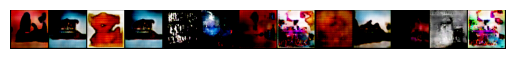

[85/200][0/158]	Loss_D: 1.5103	Loss_G: 2.2680	D(x): 1.0000	D(G(z)): 0.6868 / 0.1495
[85/200][3/158]	Loss_D: 0.0125	Loss_G: 5.8894	D(x): 0.9992	D(G(z)): 0.0116 / 0.0048
[85/200][6/158]	Loss_D: 0.0141	Loss_G: 5.1716	D(x): 0.9998	D(G(z)): 0.0137 / 0.0101
[85/200][9/158]	Loss_D: 0.0307	Loss_G: 4.5151	D(x): 0.9962	D(G(z)): 0.0262 / 0.0154
[85/200][12/158]	Loss_D: 0.1358	Loss_G: 3.5363	D(x): 0.9477	D(G(z)): 0.0736 / 0.0372
[85/200][15/158]	Loss_D: 0.4591	Loss_G: 1.3585	D(x): 0.7973	D(G(z)): 0.1716 / 0.2871
[85/200][18/158]	Loss_D: 0.0172	Loss_G: 5.9854	D(x): 1.0000	D(G(z)): 0.0167 / 0.0057
[85/200][21/158]	Loss_D: 0.0054	Loss_G: 6.1291	D(x): 0.9998	D(G(z)): 0.0052 / 0.0044
[85/200][24/158]	Loss_D: 0.0862	Loss_G: 3.6710	D(x): 0.9996	D(G(z)): 0.0797 / 0.0356
[85/200][27/158]	Loss_D: 0.0612	Loss_G: 4.9579	D(x): 0.9573	D(G(z)): 0.0155 / 0.0107
[85/200][30/158]	Loss_D: 0.0265	Loss_G: 5.1848	D(x): 0.9957	D(G(z)): 0.0216 / 0.0099
[85/200][33/158]	Loss_D: 0.0214	Loss_G: 4.7794	D(x): 0.9910	D(G(z)): 

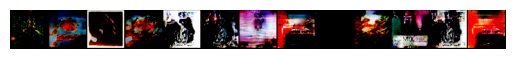

[89/200][0/158]	Loss_D: 0.0950	Loss_G: 2.6772	D(x): 0.9569	D(G(z)): 0.0462 / 0.1085
[89/200][3/158]	Loss_D: 0.1106	Loss_G: 7.4536	D(x): 0.9170	D(G(z)): 0.0092 / 0.0019
[89/200][6/158]	Loss_D: 0.0963	Loss_G: 2.3117	D(x): 0.9510	D(G(z)): 0.0418 / 0.1430
[89/200][9/158]	Loss_D: 0.0599	Loss_G: 5.2325	D(x): 0.9917	D(G(z)): 0.0473 / 0.0086
[89/200][12/158]	Loss_D: 0.0279	Loss_G: 4.4549	D(x): 0.9949	D(G(z)): 0.0223 / 0.0177
[89/200][15/158]	Loss_D: 0.3192	Loss_G: 3.6572	D(x): 0.8307	D(G(z)): 0.0954 / 0.0337
[89/200][18/158]	Loss_D: 0.1949	Loss_G: 4.7092	D(x): 0.9847	D(G(z)): 0.1510 / 0.0143
[89/200][21/158]	Loss_D: 0.2438	Loss_G: 3.1891	D(x): 0.8412	D(G(z)): 0.0425 / 0.0637
[89/200][24/158]	Loss_D: 0.1577	Loss_G: 5.7672	D(x): 0.8677	D(G(z)): 0.0072 / 0.0060
[89/200][27/158]	Loss_D: 0.1022	Loss_G: 4.0228	D(x): 0.9657	D(G(z)): 0.0619 / 0.0259
[89/200][30/158]	Loss_D: 0.4308	Loss_G: 3.3933	D(x): 0.7071	D(G(z)): 0.0064 / 0.0538
[89/200][33/158]	Loss_D: 0.1044	Loss_G: 7.1375	D(x): 0.9152	D(G(z)): 

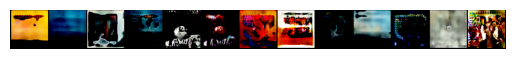

[93/200][0/158]	Loss_D: 2.6062	Loss_G: 2.3652	D(x): 1.0000	D(G(z)): 0.8734 / 0.1637
[93/200][3/158]	Loss_D: 0.0027	Loss_G: 7.8344	D(x): 0.9999	D(G(z)): 0.0026 / 0.0008
[93/200][6/158]	Loss_D: 0.0967	Loss_G: 2.4369	D(x): 1.0000	D(G(z)): 0.0876 / 0.1464
[93/200][9/158]	Loss_D: 0.0646	Loss_G: 4.7681	D(x): 1.0000	D(G(z)): 0.0601 / 0.0162
[93/200][12/158]	Loss_D: 0.1228	Loss_G: 2.8216	D(x): 1.0000	D(G(z)): 0.1105 / 0.0754
[93/200][15/158]	Loss_D: 0.0939	Loss_G: 3.9580	D(x): 1.0000	D(G(z)): 0.0858 / 0.0252
[93/200][18/158]	Loss_D: 0.0511	Loss_G: 4.0651	D(x): 0.9987	D(G(z)): 0.0474 / 0.0248
[93/200][21/158]	Loss_D: 0.0173	Loss_G: 4.7663	D(x): 0.9996	D(G(z)): 0.0167 / 0.0111
[93/200][24/158]	Loss_D: 0.3327	Loss_G: 4.1113	D(x): 1.0000	D(G(z)): 0.2621 / 0.0251
[93/200][27/158]	Loss_D: 1.5828	Loss_G: 2.4513	D(x): 0.3058	D(G(z)): 0.0164 / 0.1170
[93/200][30/158]	Loss_D: 0.4942	Loss_G: 2.8773	D(x): 0.8589	D(G(z)): 0.2571 / 0.0747
[93/200][33/158]	Loss_D: 0.5297	Loss_G: 3.1352	D(x): 0.6888	D(G(z)): 

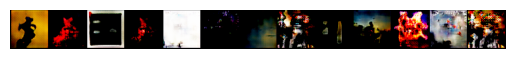

[97/200][0/158]	Loss_D: 0.3360	Loss_G: 2.4237	D(x): 1.0000	D(G(z)): 0.2572 / 0.1159
[97/200][3/158]	Loss_D: 0.0372	Loss_G: 5.1376	D(x): 1.0000	D(G(z)): 0.0354 / 0.0129
[97/200][6/158]	Loss_D: 0.0038	Loss_G: 6.3554	D(x): 1.0000	D(G(z)): 0.0038 / 0.0028
[97/200][9/158]	Loss_D: 0.0367	Loss_G: 4.3044	D(x): 1.0000	D(G(z)): 0.0345 / 0.0210
[97/200][12/158]	Loss_D: 0.0075	Loss_G: 5.9723	D(x): 1.0000	D(G(z)): 0.0074 / 0.0051
[97/200][15/158]	Loss_D: 0.0449	Loss_G: 4.0402	D(x): 1.0000	D(G(z)): 0.0432 / 0.0239
[97/200][18/158]	Loss_D: 0.0306	Loss_G: 4.4802	D(x): 0.9997	D(G(z)): 0.0295 / 0.0154
[97/200][21/158]	Loss_D: 0.0258	Loss_G: 4.5165	D(x): 0.9999	D(G(z)): 0.0246 / 0.0148
[97/200][24/158]	Loss_D: 0.0070	Loss_G: 5.3930	D(x): 0.9999	D(G(z)): 0.0069 / 0.0057
[97/200][27/158]	Loss_D: 0.0217	Loss_G: 4.5108	D(x): 0.9994	D(G(z)): 0.0208 / 0.0138
[97/200][30/158]	Loss_D: 0.0068	Loss_G: 5.5248	D(x): 0.9998	D(G(z)): 0.0066 / 0.0058
[97/200][33/158]	Loss_D: 0.0810	Loss_G: 3.9743	D(x): 0.9606	D(G(z)): 

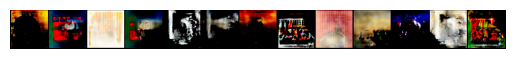

[101/200][0/158]	Loss_D: 0.1257	Loss_G: 2.5683	D(x): 1.0000	D(G(z)): 0.1133 / 0.1040
[101/200][3/158]	Loss_D: 0.0035	Loss_G: 9.9446	D(x): 0.9975	D(G(z)): 0.0009 / 0.0004
[101/200][6/158]	Loss_D: 0.0007	Loss_G: 9.3404	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[101/200][9/158]	Loss_D: 0.0047	Loss_G: 6.2125	D(x): 0.9999	D(G(z)): 0.0045 / 0.0039
[101/200][12/158]	Loss_D: 2.3754	Loss_G: 0.6473	D(x): 0.1578	D(G(z)): 0.0230 / 0.5576
[101/200][15/158]	Loss_D: 0.0024	Loss_G: 7.6567	D(x): 0.9998	D(G(z)): 0.0022 / 0.0007
[101/200][18/158]	Loss_D: 0.0043	Loss_G: 6.0542	D(x): 1.0000	D(G(z)): 0.0043 / 0.0035
[101/200][21/158]	Loss_D: 0.0779	Loss_G: 4.0519	D(x): 0.9998	D(G(z)): 0.0709 / 0.0230
[101/200][24/158]	Loss_D: 0.0064	Loss_G: 5.6684	D(x): 0.9999	D(G(z)): 0.0063 / 0.0048
[101/200][27/158]	Loss_D: 0.0053	Loss_G: 5.7322	D(x): 1.0000	D(G(z)): 0.0052 / 0.0041
[101/200][30/158]	Loss_D: 0.0233	Loss_G: 4.4130	D(x): 1.0000	D(G(z)): 0.0229 / 0.0156
[101/200][33/158]	Loss_D: 0.0402	Loss_G: 4.0549	D(x): 1.00

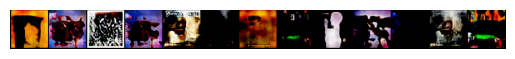

[105/200][0/158]	Loss_D: 0.2093	Loss_G: 3.1705	D(x): 1.0000	D(G(z)): 0.1256 / 0.0965
[105/200][3/158]	Loss_D: 0.1114	Loss_G: 4.2581	D(x): 0.9999	D(G(z)): 0.1018 / 0.0290
[105/200][6/158]	Loss_D: 0.0153	Loss_G: 5.3194	D(x): 0.9999	D(G(z)): 0.0150 / 0.0091
[105/200][9/158]	Loss_D: 0.0590	Loss_G: 3.9063	D(x): 1.0000	D(G(z)): 0.0560 / 0.0281
[105/200][12/158]	Loss_D: 4.2173	Loss_G: 2.0239	D(x): 0.0294	D(G(z)): 0.0059 / 0.1917
[105/200][15/158]	Loss_D: 0.0146	Loss_G: 6.1189	D(x): 1.0000	D(G(z)): 0.0144 / 0.0043
[105/200][18/158]	Loss_D: 0.0144	Loss_G: 5.3886	D(x): 1.0000	D(G(z)): 0.0140 / 0.0093
[105/200][21/158]	Loss_D: 0.0068	Loss_G: 6.0567	D(x): 0.9986	D(G(z)): 0.0054 / 0.0044
[105/200][24/158]	Loss_D: 0.0107	Loss_G: 5.2534	D(x): 0.9999	D(G(z)): 0.0105 / 0.0082
[105/200][27/158]	Loss_D: 2.1111	Loss_G: 1.1562	D(x): 0.2084	D(G(z)): 0.0303 / 0.3768
[105/200][30/158]	Loss_D: 0.0458	Loss_G: 5.0486	D(x): 1.0000	D(G(z)): 0.0436 / 0.0173
[105/200][33/158]	Loss_D: 0.0008	Loss_G: 8.6720	D(x): 1.00

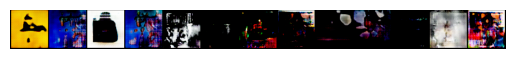

[109/200][0/158]	Loss_D: 0.4144	Loss_G: 1.8315	D(x): 1.0000	D(G(z)): 0.3069 / 0.1932
[109/200][3/158]	Loss_D: 0.0178	Loss_G: 5.7096	D(x): 0.9999	D(G(z)): 0.0171 / 0.0072
[109/200][6/158]	Loss_D: 0.0063	Loss_G: 8.2835	D(x): 0.9959	D(G(z)): 0.0022 / 0.0007
[109/200][9/158]	Loss_D: 0.1113	Loss_G: 3.2496	D(x): 1.0000	D(G(z)): 0.0961 / 0.0554
[109/200][12/158]	Loss_D: 0.0268	Loss_G: 5.1656	D(x): 1.0000	D(G(z)): 0.0261 / 0.0093
[109/200][15/158]	Loss_D: 0.1270	Loss_G: 3.5571	D(x): 0.9994	D(G(z)): 0.1127 / 0.0374
[109/200][18/158]	Loss_D: 0.0098	Loss_G: 5.4372	D(x): 0.9983	D(G(z)): 0.0081 / 0.0062
[109/200][21/158]	Loss_D: 0.0307	Loss_G: 4.2700	D(x): 0.9993	D(G(z)): 0.0293 / 0.0186
[109/200][24/158]	Loss_D: 0.0128	Loss_G: 5.2027	D(x): 0.9979	D(G(z)): 0.0105 / 0.0080
[109/200][27/158]	Loss_D: 0.0116	Loss_G: 5.1659	D(x): 0.9987	D(G(z)): 0.0102 / 0.0077
[109/200][30/158]	Loss_D: 0.3356	Loss_G: 2.3506	D(x): 1.0000	D(G(z)): 0.2597 / 0.1424
[109/200][33/158]	Loss_D: 0.0586	Loss_G: 4.6043	D(x): 0.99

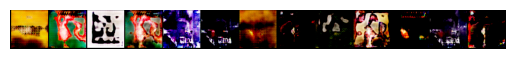

[113/200][0/158]	Loss_D: 0.1160	Loss_G: 2.6524	D(x): 1.0000	D(G(z)): 0.1040 / 0.1105
[113/200][3/158]	Loss_D: 0.0366	Loss_G: 7.3629	D(x): 0.9808	D(G(z)): 0.0155 / 0.0050
[113/200][6/158]	Loss_D: 0.0029	Loss_G: 7.3599	D(x): 0.9999	D(G(z)): 0.0028 / 0.0021
[113/200][9/158]	Loss_D: 0.1072	Loss_G: 1.8556	D(x): 1.0000	D(G(z)): 0.0918 / 0.1975
[113/200][12/158]	Loss_D: 0.0045	Loss_G: 7.5609	D(x): 1.0000	D(G(z)): 0.0044 / 0.0019
[113/200][15/158]	Loss_D: 0.0016	Loss_G: 7.9526	D(x): 1.0000	D(G(z)): 0.0016 / 0.0014
[113/200][18/158]	Loss_D: 0.0020	Loss_G: 7.5428	D(x): 0.9999	D(G(z)): 0.0019 / 0.0018
[113/200][21/158]	Loss_D: 0.0196	Loss_G: 5.3893	D(x): 1.0000	D(G(z)): 0.0189 / 0.0107
[113/200][24/158]	Loss_D: 2.3964	Loss_G: 1.2657	D(x): 0.1504	D(G(z)): 0.0218 / 0.3442
[113/200][27/158]	Loss_D: 0.0313	Loss_G: 5.2982	D(x): 1.0000	D(G(z)): 0.0304 / 0.0086
[113/200][30/158]	Loss_D: 0.0631	Loss_G: 2.8900	D(x): 1.0000	D(G(z)): 0.0602 / 0.0665
[113/200][33/158]	Loss_D: 0.0481	Loss_G: 4.2406	D(x): 1.00

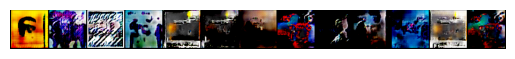

[117/200][0/158]	Loss_D: 0.0259	Loss_G: 5.0751	D(x): 1.0000	D(G(z)): 0.0251 / 0.0146
[117/200][3/158]	Loss_D: 0.8905	Loss_G: 2.8113	D(x): 0.6489	D(G(z)): 0.1033 / 0.1392
[117/200][6/158]	Loss_D: 0.0667	Loss_G: 4.7479	D(x): 1.0000	D(G(z)): 0.0562 / 0.0153
[117/200][9/158]	Loss_D: 0.0257	Loss_G: 4.3602	D(x): 1.0000	D(G(z)): 0.0252 / 0.0172
[117/200][12/158]	Loss_D: 0.0429	Loss_G: 4.2648	D(x): 1.0000	D(G(z)): 0.0413 / 0.0207
[117/200][15/158]	Loss_D: 0.0157	Loss_G: 4.8067	D(x): 1.0000	D(G(z)): 0.0155 / 0.0111
[117/200][18/158]	Loss_D: 1.1087	Loss_G: 1.5758	D(x): 0.4516	D(G(z)): 0.1015 / 0.2469
[117/200][21/158]	Loss_D: 0.0954	Loss_G: 4.4936	D(x): 1.0000	D(G(z)): 0.0843 / 0.0217
[117/200][24/158]	Loss_D: 0.0111	Loss_G: 5.4982	D(x): 1.0000	D(G(z)): 0.0110 / 0.0073
[117/200][27/158]	Loss_D: 0.0092	Loss_G: 5.4932	D(x): 1.0000	D(G(z)): 0.0091 / 0.0071
[117/200][30/158]	Loss_D: 0.0632	Loss_G: 3.0663	D(x): 1.0000	D(G(z)): 0.0590 / 0.0679
[117/200][33/158]	Loss_D: 0.3659	Loss_G: 3.1226	D(x): 0.82

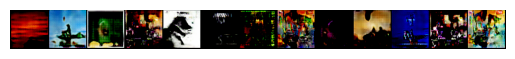

[121/200][0/158]	Loss_D: 0.0106	Loss_G: 5.1083	D(x): 1.0000	D(G(z)): 0.0104 / 0.0091
[121/200][3/158]	Loss_D: 0.6404	Loss_G: 3.5387	D(x): 1.0000	D(G(z)): 0.4484 / 0.0363
[121/200][6/158]	Loss_D: 0.0074	Loss_G: 6.0784	D(x): 0.9984	D(G(z)): 0.0057 / 0.0035
[121/200][9/158]	Loss_D: 0.0045	Loss_G: 6.1376	D(x): 1.0000	D(G(z)): 0.0044 / 0.0038
[121/200][12/158]	Loss_D: 0.0032	Loss_G: 6.1986	D(x): 1.0000	D(G(z)): 0.0031 / 0.0028
[121/200][15/158]	Loss_D: 0.2625	Loss_G: 3.0368	D(x): 1.0000	D(G(z)): 0.2194 / 0.0631
[121/200][18/158]	Loss_D: 0.0063	Loss_G: 6.2034	D(x): 1.0000	D(G(z)): 0.0063 / 0.0029
[121/200][21/158]	Loss_D: 0.2503	Loss_G: 2.1398	D(x): 1.0000	D(G(z)): 0.2077 / 0.1398
[121/200][24/158]	Loss_D: 0.0406	Loss_G: 4.1444	D(x): 1.0000	D(G(z)): 0.0392 / 0.0207
[121/200][27/158]	Loss_D: 0.0034	Loss_G: 6.5539	D(x): 1.0000	D(G(z)): 0.0034 / 0.0025
[121/200][30/158]	Loss_D: 0.0192	Loss_G: 4.5583	D(x): 0.9995	D(G(z)): 0.0184 / 0.0139
[121/200][33/158]	Loss_D: 0.0137	Loss_G: 4.8174	D(x): 0.99

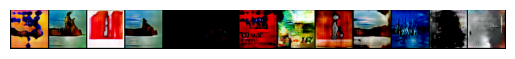

[125/200][0/158]	Loss_D: 0.6188	Loss_G: 2.5864	D(x): 0.9985	D(G(z)): 0.4190 / 0.1034
[125/200][3/158]	Loss_D: 0.0070	Loss_G: 6.3223	D(x): 0.9994	D(G(z)): 0.0064 / 0.0033
[125/200][6/158]	Loss_D: 0.0169	Loss_G: 4.8091	D(x): 0.9991	D(G(z)): 0.0158 / 0.0112
[125/200][9/158]	Loss_D: 0.0561	Loss_G: 3.6838	D(x): 0.9991	D(G(z)): 0.0528 / 0.0313
[125/200][12/158]	Loss_D: 0.0228	Loss_G: 4.5897	D(x): 0.9986	D(G(z)): 0.0210 / 0.0135
[125/200][15/158]	Loss_D: 0.0319	Loss_G: 4.4672	D(x): 0.9957	D(G(z)): 0.0254 / 0.0157
[125/200][18/158]	Loss_D: 0.0949	Loss_G: 2.3865	D(x): 0.9999	D(G(z)): 0.0885 / 0.1090
[125/200][21/158]	Loss_D: 0.0032	Loss_G: 8.8701	D(x): 0.9984	D(G(z)): 0.0016 / 0.0007
[125/200][24/158]	Loss_D: 0.0017	Loss_G: 8.3004	D(x): 0.9996	D(G(z)): 0.0013 / 0.0011
[125/200][27/158]	Loss_D: 0.0014	Loss_G: 8.1601	D(x): 0.9996	D(G(z)): 0.0010 / 0.0009
[125/200][30/158]	Loss_D: 0.0098	Loss_G: 7.0577	D(x): 0.9930	D(G(z)): 0.0028 / 0.0026
[125/200][33/158]	Loss_D: 0.0057	Loss_G: 6.3652	D(x): 0.99

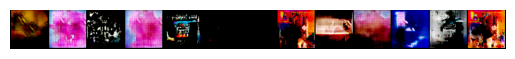

[129/200][0/158]	Loss_D: 0.1966	Loss_G: 2.0116	D(x): 1.0000	D(G(z)): 0.1417 / 0.1899
[129/200][3/158]	Loss_D: 0.8323	Loss_G: 3.8383	D(x): 0.5575	D(G(z)): 0.0377 / 0.1052
[129/200][6/158]	Loss_D: 0.0303	Loss_G: 5.7735	D(x): 1.0000	D(G(z)): 0.0291 / 0.0193
[129/200][9/158]	Loss_D: 0.0188	Loss_G: 5.2424	D(x): 0.9999	D(G(z)): 0.0183 / 0.0138
[129/200][12/158]	Loss_D: 0.0222	Loss_G: 4.9053	D(x): 1.0000	D(G(z)): 0.0215 / 0.0142
[129/200][15/158]	Loss_D: 0.0182	Loss_G: 4.9458	D(x): 1.0000	D(G(z)): 0.0179 / 0.0106
[129/200][18/158]	Loss_D: 0.0306	Loss_G: 4.6890	D(x): 0.9969	D(G(z)): 0.0266 / 0.0138
[129/200][21/158]	Loss_D: 0.0625	Loss_G: 4.3568	D(x): 0.9991	D(G(z)): 0.0528 / 0.0185
[129/200][24/158]	Loss_D: 0.0091	Loss_G: 5.5389	D(x): 1.0000	D(G(z)): 0.0090 / 0.0054
[129/200][27/158]	Loss_D: 0.0315	Loss_G: 4.3230	D(x): 0.9982	D(G(z)): 0.0290 / 0.0172
[129/200][30/158]	Loss_D: 0.0109	Loss_G: 5.0644	D(x): 0.9999	D(G(z)): 0.0108 / 0.0079
[129/200][33/158]	Loss_D: 0.1182	Loss_G: 3.8303	D(x): 1.00

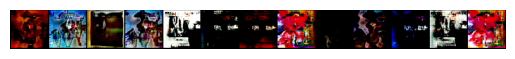

[133/200][0/158]	Loss_D: 0.1302	Loss_G: 4.4644	D(x): 1.0000	D(G(z)): 0.1113 / 0.0386
[133/200][3/158]	Loss_D: 0.0093	Loss_G: 6.6115	D(x): 1.0000	D(G(z)): 0.0090 / 0.0031
[133/200][6/158]	Loss_D: 1.7392	Loss_G: 4.1485	D(x): 0.3155	D(G(z)): 0.0039 / 0.0250
[133/200][9/158]	Loss_D: 0.1083	Loss_G: 3.9865	D(x): 0.9999	D(G(z)): 0.0982 / 0.0240
[133/200][12/158]	Loss_D: 0.0224	Loss_G: 4.7149	D(x): 1.0000	D(G(z)): 0.0219 / 0.0123
[133/200][15/158]	Loss_D: 0.0165	Loss_G: 4.7833	D(x): 0.9999	D(G(z)): 0.0162 / 0.0121
[133/200][18/158]	Loss_D: 0.1545	Loss_G: 3.5456	D(x): 1.0000	D(G(z)): 0.1384 / 0.0367
[133/200][21/158]	Loss_D: 0.0268	Loss_G: 3.6778	D(x): 1.0000	D(G(z)): 0.0263 / 0.0330
[133/200][24/158]	Loss_D: 0.0380	Loss_G: 4.3047	D(x): 0.9998	D(G(z)): 0.0368 / 0.0167
[133/200][27/158]	Loss_D: 0.0084	Loss_G: 5.5144	D(x): 1.0000	D(G(z)): 0.0083 / 0.0057
[133/200][30/158]	Loss_D: 0.9920	Loss_G: 1.7293	D(x): 0.4914	D(G(z)): 0.0831 / 0.2234
[133/200][33/158]	Loss_D: 0.0972	Loss_G: 3.7423	D(x): 1.00

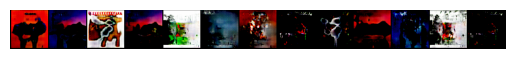

[137/200][0/158]	Loss_D: 0.1552	Loss_G: 2.6335	D(x): 0.9947	D(G(z)): 0.1282 / 0.1076
[137/200][3/158]	Loss_D: 0.2601	Loss_G: 3.8818	D(x): 1.0000	D(G(z)): 0.2147 / 0.0280
[137/200][6/158]	Loss_D: 0.0025	Loss_G: 6.8630	D(x): 0.9996	D(G(z)): 0.0021 / 0.0015
[137/200][9/158]	Loss_D: 0.0028	Loss_G: 6.5639	D(x): 0.9998	D(G(z)): 0.0026 / 0.0024
[137/200][12/158]	Loss_D: 0.0056	Loss_G: 5.9448	D(x): 0.9980	D(G(z)): 0.0036 / 0.0034
[137/200][15/158]	Loss_D: 3.1952	Loss_G: 2.6131	D(x): 0.0693	D(G(z)): 0.0036 / 0.1000
[137/200][18/158]	Loss_D: 0.0137	Loss_G: 5.6469	D(x): 0.9997	D(G(z)): 0.0133 / 0.0068
[137/200][21/158]	Loss_D: 0.0013	Loss_G: 7.3872	D(x): 1.0000	D(G(z)): 0.0013 / 0.0011
[137/200][24/158]	Loss_D: 0.0113	Loss_G: 5.2207	D(x): 1.0000	D(G(z)): 0.0111 / 0.0094
[137/200][27/158]	Loss_D: 0.0501	Loss_G: 3.9777	D(x): 0.9999	D(G(z)): 0.0478 / 0.0288
[137/200][30/158]	Loss_D: 0.0096	Loss_G: 5.4858	D(x): 0.9976	D(G(z)): 0.0072 / 0.0061
[137/200][33/158]	Loss_D: 0.0037	Loss_G: 6.1927	D(x): 1.00

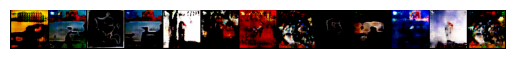

[141/200][0/158]	Loss_D: 1.1647	Loss_G: 9.5645	D(x): 0.9973	D(G(z)): 0.6102 / 0.0003
[141/200][3/158]	Loss_D: 0.5393	Loss_G: 5.9108	D(x): 0.6970	D(G(z)): 0.0021 / 0.0048
[141/200][6/158]	Loss_D: 0.0103	Loss_G: 6.6012	D(x): 0.9978	D(G(z)): 0.0080 / 0.0027
[141/200][9/158]	Loss_D: 0.8168	Loss_G: 2.1298	D(x): 0.5672	D(G(z)): 0.0910 / 0.1634
[141/200][12/158]	Loss_D: 0.0377	Loss_G: 4.4489	D(x): 0.9997	D(G(z)): 0.0354 / 0.0177
[141/200][15/158]	Loss_D: 0.0412	Loss_G: 4.4089	D(x): 0.9980	D(G(z)): 0.0375 / 0.0166
[141/200][18/158]	Loss_D: 0.0602	Loss_G: 3.9197	D(x): 0.9880	D(G(z)): 0.0462 / 0.0256
[141/200][21/158]	Loss_D: 0.0063	Loss_G: 5.8254	D(x): 0.9984	D(G(z)): 0.0047 / 0.0038
[141/200][24/158]	Loss_D: 0.0228	Loss_G: 4.5302	D(x): 0.9971	D(G(z)): 0.0195 / 0.0143
[141/200][27/158]	Loss_D: 0.0185	Loss_G: 6.3760	D(x): 0.9847	D(G(z)): 0.0029 / 0.0023
[141/200][30/158]	Loss_D: 0.1207	Loss_G: 3.7072	D(x): 0.9458	D(G(z)): 0.0601 / 0.0297
[141/200][33/158]	Loss_D: 0.3141	Loss_G: 4.9307	D(x): 0.75

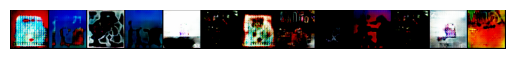

[145/200][0/158]	Loss_D: 0.6600	Loss_G: 2.4919	D(x): 1.0000	D(G(z)): 0.4087 / 0.1871
[145/200][3/158]	Loss_D: 0.0245	Loss_G: 5.9637	D(x): 1.0000	D(G(z)): 0.0232 / 0.0099
[145/200][6/158]	Loss_D: 0.2957	Loss_G: 3.6387	D(x): 0.9999	D(G(z)): 0.2322 / 0.0411
[145/200][9/158]	Loss_D: 0.0172	Loss_G: 5.4986	D(x): 0.9971	D(G(z)): 0.0140 / 0.0097
[145/200][12/158]	Loss_D: 0.0115	Loss_G: 5.2864	D(x): 0.9999	D(G(z)): 0.0113 / 0.0072
[145/200][15/158]	Loss_D: 0.0298	Loss_G: 5.0180	D(x): 0.9827	D(G(z)): 0.0121 / 0.0095
[145/200][18/158]	Loss_D: 0.0606	Loss_G: 3.8449	D(x): 0.9983	D(G(z)): 0.0559 / 0.0273
[145/200][21/158]	Loss_D: 0.0595	Loss_G: 3.8729	D(x): 0.9998	D(G(z)): 0.0567 / 0.0263
[145/200][24/158]	Loss_D: 0.0163	Loss_G: 4.9939	D(x): 0.9968	D(G(z)): 0.0129 / 0.0095
[145/200][27/158]	Loss_D: 0.0250	Loss_G: 4.5720	D(x): 0.9978	D(G(z)): 0.0223 / 0.0138
[145/200][30/158]	Loss_D: 0.2871	Loss_G: 4.1633	D(x): 0.7782	D(G(z)): 0.0143 / 0.0207
[145/200][33/158]	Loss_D: 0.0149	Loss_G: 4.9246	D(x): 0.99

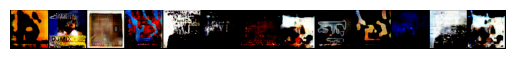

[149/200][0/158]	Loss_D: 0.1127	Loss_G: 3.4567	D(x): 0.9689	D(G(z)): 0.0658 / 0.0551
[149/200][3/158]	Loss_D: 0.0080	Loss_G: 6.3795	D(x): 0.9991	D(G(z)): 0.0070 / 0.0047
[149/200][6/158]	Loss_D: 0.1675	Loss_G: 3.3643	D(x): 0.9585	D(G(z)): 0.1076 / 0.0514
[149/200][9/158]	Loss_D: 0.2262	Loss_G: 5.2480	D(x): 0.8381	D(G(z)): 0.0071 / 0.0082
[149/200][12/158]	Loss_D: 0.0939	Loss_G: 4.2704	D(x): 0.9673	D(G(z)): 0.0568 / 0.0192
[149/200][15/158]	Loss_D: 0.0987	Loss_G: 4.3541	D(x): 0.9504	D(G(z)): 0.0430 / 0.0174
[149/200][18/158]	Loss_D: 0.0469	Loss_G: 4.1150	D(x): 0.9680	D(G(z)): 0.0128 / 0.0252
[149/200][21/158]	Loss_D: 0.0333	Loss_G: 7.1072	D(x): 0.9752	D(G(z)): 0.0076 / 0.0013
[149/200][24/158]	Loss_D: 0.0840	Loss_G: 4.1134	D(x): 0.9520	D(G(z)): 0.0298 / 0.0242
[149/200][27/158]	Loss_D: 0.1529	Loss_G: 3.7501	D(x): 0.9018	D(G(z)): 0.0386 / 0.0320
[149/200][30/158]	Loss_D: 0.1398	Loss_G: 4.1493	D(x): 0.9156	D(G(z)): 0.0425 / 0.0221
[149/200][33/158]	Loss_D: 0.1376	Loss_G: 4.0783	D(x): 0.89

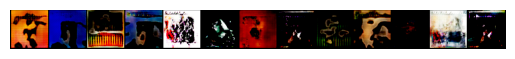

[153/200][0/158]	Loss_D: 0.0074	Loss_G: 6.3116	D(x): 1.0000	D(G(z)): 0.0072 / 0.0061
[153/200][3/158]	Loss_D: 0.0052	Loss_G: 5.8879	D(x): 1.0000	D(G(z)): 0.0052 / 0.0041
[153/200][6/158]	Loss_D: 0.1606	Loss_G: 2.5196	D(x): 0.9998	D(G(z)): 0.1387 / 0.0963
[153/200][9/158]	Loss_D: 0.1325	Loss_G: 3.9785	D(x): 0.9951	D(G(z)): 0.1165 / 0.0232
[153/200][12/158]	Loss_D: 0.0015	Loss_G: 7.1525	D(x): 1.0000	D(G(z)): 0.0015 / 0.0012
[153/200][15/158]	Loss_D: 0.0744	Loss_G: 3.7786	D(x): 0.9997	D(G(z)): 0.0663 / 0.0291
[153/200][18/158]	Loss_D: 0.0036	Loss_G: 6.2336	D(x): 1.0000	D(G(z)): 0.0036 / 0.0029
[153/200][21/158]	Loss_D: 0.0085	Loss_G: 5.4268	D(x): 0.9985	D(G(z)): 0.0070 / 0.0056
[153/200][24/158]	Loss_D: 0.0161	Loss_G: 4.8133	D(x): 0.9981	D(G(z)): 0.0141 / 0.0111
[153/200][27/158]	Loss_D: 0.0056	Loss_G: 5.6493	D(x): 0.9998	D(G(z)): 0.0054 / 0.0048
[153/200][30/158]	Loss_D: 0.0119	Loss_G: 4.9252	D(x): 0.9995	D(G(z)): 0.0114 / 0.0096
[153/200][33/158]	Loss_D: 0.0177	Loss_G: 4.6598	D(x): 0.99

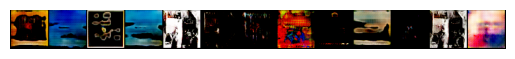

[157/200][0/158]	Loss_D: 0.5728	Loss_G: 2.5534	D(x): 1.0000	D(G(z)): 0.3861 / 0.1226
[157/200][3/158]	Loss_D: 0.0269	Loss_G: 5.2307	D(x): 1.0000	D(G(z)): 0.0262 / 0.0092
[157/200][6/158]	Loss_D: 0.0044	Loss_G: 6.1349	D(x): 0.9999	D(G(z)): 0.0043 / 0.0035
[157/200][9/158]	Loss_D: 0.0109	Loss_G: 5.4007	D(x): 0.9999	D(G(z)): 0.0107 / 0.0070
[157/200][12/158]	Loss_D: 0.0094	Loss_G: 5.3156	D(x): 1.0000	D(G(z)): 0.0093 / 0.0069
[157/200][15/158]	Loss_D: 0.0033	Loss_G: 6.2573	D(x): 0.9998	D(G(z)): 0.0031 / 0.0026
[157/200][18/158]	Loss_D: 0.0162	Loss_G: 4.7217	D(x): 1.0000	D(G(z)): 0.0159 / 0.0120
[157/200][21/158]	Loss_D: 0.0750	Loss_G: 4.2737	D(x): 1.0000	D(G(z)): 0.0694 / 0.0201
[157/200][24/158]	Loss_D: 0.0216	Loss_G: 5.1097	D(x): 1.0000	D(G(z)): 0.0211 / 0.0099
[157/200][27/158]	Loss_D: 0.0064	Loss_G: 5.9442	D(x): 0.9999	D(G(z)): 0.0063 / 0.0043
[157/200][30/158]	Loss_D: 0.1442	Loss_G: 5.1698	D(x): 0.9999	D(G(z)): 0.1264 / 0.0094
[157/200][33/158]	Loss_D: 0.0121	Loss_G: 5.5059	D(x): 0.99

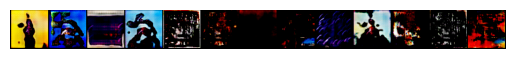

[161/200][0/158]	Loss_D: 0.0285	Loss_G: 4.3863	D(x): 1.0000	D(G(z)): 0.0276 / 0.0271
[161/200][3/158]	Loss_D: 0.0089	Loss_G: 5.8531	D(x): 1.0000	D(G(z)): 0.0087 / 0.0053
[161/200][6/158]	Loss_D: 0.0243	Loss_G: 4.5767	D(x): 1.0000	D(G(z)): 0.0236 / 0.0164
[161/200][9/158]	Loss_D: 0.0144	Loss_G: 5.0211	D(x): 1.0000	D(G(z)): 0.0141 / 0.0107
[161/200][12/158]	Loss_D: 0.0536	Loss_G: 4.2861	D(x): 1.0000	D(G(z)): 0.0514 / 0.0187
[161/200][15/158]	Loss_D: 0.0293	Loss_G: 4.3660	D(x): 1.0000	D(G(z)): 0.0287 / 0.0168
[161/200][18/158]	Loss_D: 0.3358	Loss_G: 3.2365	D(x): 1.0000	D(G(z)): 0.2617 / 0.0499
[161/200][21/158]	Loss_D: 0.0150	Loss_G: 5.0173	D(x): 1.0000	D(G(z)): 0.0149 / 0.0098
[161/200][24/158]	Loss_D: 0.7467	Loss_G: 2.2385	D(x): 0.5827	D(G(z)): 0.0617 / 0.1360
[161/200][27/158]	Loss_D: 0.1604	Loss_G: 3.4759	D(x): 1.0000	D(G(z)): 0.1382 / 0.0390
[161/200][30/158]	Loss_D: 0.0189	Loss_G: 4.7187	D(x): 1.0000	D(G(z)): 0.0185 / 0.0127
[161/200][33/158]	Loss_D: 0.0232	Loss_G: 4.6166	D(x): 1.00

KeyboardInterrupt: ignored

In [25]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        embed_label = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, embed_label).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)

        # Generate fake image batch with G
        fake = netG(noise, embed_label)
        fake = fake.view(b_size, 3, 64, 64)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach(), embed_label).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, embed_label).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 3 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise, embed_label).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # save model periodically
    if epoch % 4 == 0 or epoch == int(num_epochs - 1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)

        torch.save(netD.state_dict(), save_dir + f"/netD_{epoch + epochs_}.pth")
        print("saved model at " + save_dir + f"/netD_{epoch + epochs_}.pth")
        torch.save(netG.state_dict(), save_dir + f"/netG_{epoch + epochs_}.pth")
        print("saved model at " + save_dir + f"/netG_{epoch + epochs_}.pth")

        torch.save(optimizerG.state_dict(), save_dir + f"/optG_{epoch + epochs_}.pth")
        torch.save(optimizerD.state_dict(), save_dir + f"/optD_{epoch + epochs_}.pth")
        print("saved model at " + save_dir + f"/opt_{epoch + epochs_}.pth")

        fake = netG(fixed_noise[:13], embed_label).detach().cpu()
        grid = make_grid(fake, nrow=16)
        array = grid.permute(1, 2, 0).numpy()

        # Show image with matplotlib
        plt.imshow(array)
        plt.axis('off')
        plt.show()


In [26]:
print(epoch)
print(iters)

162
25650


In [27]:
import pickle

with open("../artifacts/weights_gan/cover_G_losses.pkl", "wb") as file:
    pickle.dump(G_losses, file)
with open("../artifacts/weights_gan/cover_D_losses.pkl", "wb") as file:
    pickle.dump(D_losses, file)
with open("../artifacts/weights_gan/cover_img_list.pkl", "wb") as file:
    pickle.dump(img_list, file)

## Results

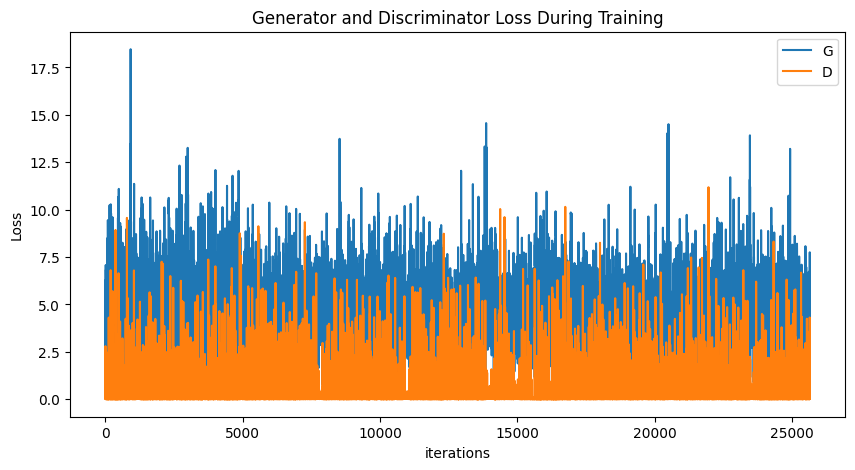

In [28]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

In [29]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**



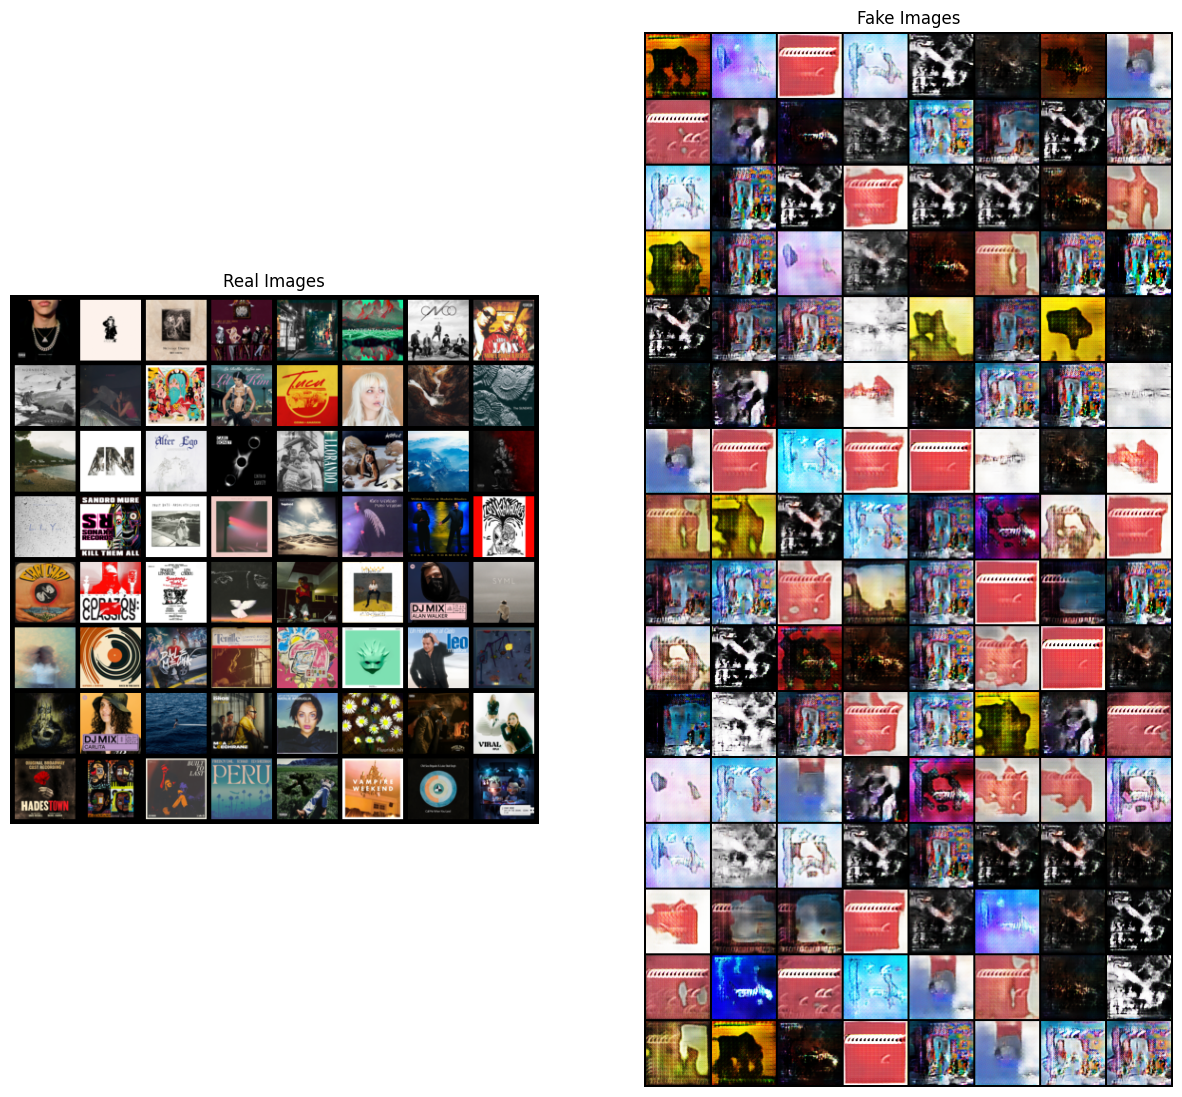

In [31]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()